# Setup

In [64]:
import os
import pandas as pd
import pickle
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)

AIRBNB_PATH = os.path.join("data", "airbnb")
AIRBNB_MODEL = os.path.join("models", "airbnb")

def get_data_from_csv_file(file_name, aribnb_path=AIRBNB_PATH):
    path = os.path.join(aribnb_path, file_name)
    return pd.read_csv(path)

def save_to_csv(df, file_name, airbnb_path=AIRBNB_PATH):
    path = os.path.join(airbnb_path, file_name)
    return df.to_csv(path, index=False)

def save_model(kmeans_model, file_name="kmeans_model.pkl", airbnb_path=AIRBNB_MODEL):
    path = os.path.join(airbnb_path, file_name)
    with open(path, "wb") as file:
        pickle.dump(kmeans_model, file)

# Kmeans - Clustering Based On Numerical Variables Only

In [65]:
airbnb = get_data_from_csv_file("airbnb_processed_data.csv")
airbnb.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,t,moderate,t,1,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1,1,2,Real Bed,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
1,f,strict_14_with_grace_period,f,2,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1,2,3,Real Bed,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0
2,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2,4,1,1,Real Bed,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0
3,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4,1,1,Real Bed,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0
4,f,strict_14_with_grace_period,f,2,Western Addition,37.77525,-122.43637,House,Entire home/apt,5,1,2,2,Real Bed,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0


In [66]:
categorical_variables = []
for column in list(airbnb.columns):
    if airbnb[column].dtype == "O":
        categorical_variables.append(column)

numerical_variables = []
for column in list(airbnb.columns):
    if airbnb[column].dtype != "O":
        numerical_variables.append(column)

In [67]:
categorical_variables

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [68]:
numerical_variables

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

In [69]:
airbnb = airbnb.drop(categorical_variables, axis=1)
airbnb.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,1,37.76931,-122.43386,3,1,1,2,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
1,2,37.74511,-122.42102,5,1,2,3,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0
2,10,37.76669,-12.24525,2,4,1,1,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0
3,10,37.76487,-122.45183,2,4,1,1,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0
4,2,37.77525,-122.43637,5,1,2,2,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0


In [70]:
for column in numerical_variables:
    if column not in ["latitude", "longitude"]:
        scaler = StandardScaler()
        airbnb[column] = scaler.fit_transform(
            np.reshape(airbnb[column].values, (airbnb.shape[0], 1))
        )

airbnb_prepared = airbnb.to_numpy()

In [71]:
airbnb.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,-0.290869,37.76931,-122.43386,-0.105021,-0.358986,-0.367403,0.200149,-0.658275,1.881149,0.153637,0.298499,0.426877,0.232049,0.243423,0.426052,0.632892,-0.139102
1,-0.285233,37.74511,-122.42102,0.939485,-0.358986,0.704651,1.049978,0.630039,0.929863,0.312728,0.298499,0.426877,0.232049,0.243423,0.426052,-0.697690,0.069664
2,-0.240141,37.76669,-12.24525,-0.627273,3.531782,-0.367403,-0.649681,0.718888,-0.366092,-1.755459,-3.024048,-2.414728,-1.996748,-1.670222,-1.090922,-2.028272,-0.476339
3,-0.240141,37.76487,-122.45183,-0.627273,3.531782,-0.367403,-0.649681,0.718888,-0.490172,-0.482728,-1.362774,-0.993925,0.232049,0.243423,-1.090922,-0.697690,-0.476339
4,-0.285233,37.77525,-122.43637,0.939485,-0.358986,0.704651,0.200149,-0.391727,-0.228224,0.153637,0.298499,0.426877,0.232049,0.243423,0.426052,-0.697690,1.836144


In [72]:
airbnb_prepared.shape

(7146, 17)

In [73]:
_, num_columns = airbnb_prepared.shape

In [74]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(airbnb_prepared)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(airbnb_prepared, model.labels_)
                     for model in kmeans_per_k[1:]]

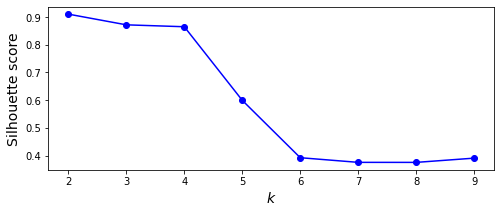

In [75]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [76]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(airbnb_prepared)

In [77]:
airbnb["cluster"] = kmeans.labels_
airbnb.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,-0.290869,37.76931,-122.43386,-0.105021,-0.358986,-0.367403,0.200149,-0.658275,1.881149,0.153637,0.298499,0.426877,0.232049,0.243423,0.426052,0.632892,-0.139102,1
1,-0.285233,37.74511,-122.42102,0.939485,-0.358986,0.704651,1.049978,0.630039,0.929863,0.312728,0.298499,0.426877,0.232049,0.243423,0.426052,-0.697690,0.069664,1
2,-0.240141,37.76669,-12.24525,-0.627273,3.531782,-0.367403,-0.649681,0.718888,-0.366092,-1.755459,-3.024048,-2.414728,-1.996748,-1.670222,-1.090922,-2.028272,-0.476339,0
3,-0.240141,37.76487,-122.45183,-0.627273,3.531782,-0.367403,-0.649681,0.718888,-0.490172,-0.482728,-1.362774,-0.993925,0.232049,0.243423,-1.090922,-0.697690,-0.476339,1
4,-0.285233,37.77525,-122.43637,0.939485,-0.358986,0.704651,0.200149,-0.391727,-0.228224,0.153637,0.298499,0.426877,0.232049,0.243423,0.426052,-0.697690,1.836144,1


In [78]:
clf = RandomForestClassifier(random_state=42)

clf.fit(airbnb_prepared, airbnb["cluster"].values)

sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]

most_important_features = np.take_along_axis(
    np.array(airbnb.iloc[:, 0:num_columns].columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

list(zip(most_important_features, most_important_weights))

[('longitude', 0.9612423921570836),
 ('latitude', 0.008699556912242109),
 ('price', 0.005202549796837799),
 ('number_of_reviews', 0.0040730794911525885),
 ('review_scores_rating', 0.002901535001578044),
 ('host_total_listings_count', 0.0023428715657861604),
 ('minimum_nights', 0.0022483986696403852),
 ('accommodates', 0.00212173506384102),
 ('beds', 0.001789399381013401),
 ('review_scores_communication', 0.0014887138193145169),
 ('bathrooms', 0.0014826630553518628),
 ('review_scores_value', 0.0012491562294762318),
 ('review_scores_location', 0.0012051437250027912),
 ('review_scores_cleanliness', 0.0012013485170004885),
 ('bedrooms', 0.001033702957221102),
 ('review_scores_checkin', 0.0008840698287221381),
 ('review_scores_accuracy', 0.0008336838287356352)]

In [79]:
airbnb_ = airbnb.copy()
airbnb_.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,-0.290869,37.76931,-122.43386,-0.105021,-0.358986,-0.367403,0.200149,-0.658275,1.881149,0.153637,0.298499,0.426877,0.232049,0.243423,0.426052,0.632892,-0.139102,1
1,-0.285233,37.74511,-122.42102,0.939485,-0.358986,0.704651,1.049978,0.630039,0.929863,0.312728,0.298499,0.426877,0.232049,0.243423,0.426052,-0.697690,0.069664,1
2,-0.240141,37.76669,-12.24525,-0.627273,3.531782,-0.367403,-0.649681,0.718888,-0.366092,-1.755459,-3.024048,-2.414728,-1.996748,-1.670222,-1.090922,-2.028272,-0.476339,0
3,-0.240141,37.76487,-122.45183,-0.627273,3.531782,-0.367403,-0.649681,0.718888,-0.490172,-0.482728,-1.362774,-0.993925,0.232049,0.243423,-1.090922,-0.697690,-0.476339,1
4,-0.285233,37.77525,-122.43637,0.939485,-0.358986,0.704651,0.200149,-0.391727,-0.228224,0.153637,0.298499,0.426877,0.232049,0.243423,0.426052,-0.697690,1.836144,1


In [80]:
airbnb = get_data_from_csv_file("airbnb_processed_data.csv")
airbnb.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,t,moderate,t,1,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1,1,2,Real Bed,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
1,f,strict_14_with_grace_period,f,2,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1,2,3,Real Bed,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0
2,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2,4,1,1,Real Bed,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0
3,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4,1,1,Real Bed,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0
4,f,strict_14_with_grace_period,f,2,Western Addition,37.77525,-122.43637,House,Entire home/apt,5,1,2,2,Real Bed,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0


In [81]:
airbnb["cluster"] = airbnb_["cluster"]
airbnb.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,t,moderate,t,1,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1,1,2,Real Bed,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,1
1,f,strict_14_with_grace_period,f,2,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1,2,3,Real Bed,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,1
2,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2,4,1,1,Real Bed,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,0
3,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4,1,1,Real Bed,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,1
4,f,strict_14_with_grace_period,f,2,Western Addition,37.77525,-122.43637,House,Entire home/apt,5,1,2,2,Real Bed,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0,1


In [82]:
airbnb.groupby("cluster").mean()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
cluster,,,,,,,,,,,,,,,,,
0,52.351351,34.268070,-11.034270,3.123755,1.238976,1.311522,1.725462,15.483642,41.591750,95.897582,9.810811,9.660028,9.893314,9.880512,9.726885,9.510669,194.998578
1,52.632625,34.312453,-122.430756,3.209530,1.280925,1.346112,1.768741,15.854260,43.767965,96.049201,9.821357,9.703865,9.896166,9.871954,9.718299,9.525842,215.307776


In [83]:
save_to_csv(airbnb, "kmeans_cluster_based_on_numerical_variables_only.csv")

# Kmeans - Clustering Again Based On Categorical and Numerical Variables

### Cluster 0

In [84]:
airbnb_0 = airbnb[airbnb["cluster"] == 0].reset_index(drop=True)
airbnb_0.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2,4,1,1,Real Bed,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,0
1,t,strict_14_with_grace_period,f,2,Potrero Hill,37.75645,-12.23991,Apartment,Private room,2,1,1,1,Real Bed,2,272,98.0,10.0,10.0,10.0,10.0,10.0,9.0,155.0,0
2,f,strict_14_with_grace_period,t,2,Western Addition,37.77478,-12.24315,Apartment,Entire home/apt,10,2,4,7,Real Bed,2,31,90.0,9.0,8.0,9.0,9.0,9.0,9.0,450.0,0
3,t,moderate,f,9,Pacific Heights,37.79312,-1.22426,Apartment,Private room,1,0,1,1,Real Bed,30,160,92.0,10.0,9.0,10.0,10.0,10.0,9.0,55.0,0
4,t,moderate,f,9,Pacific Heights,37.79166,-12.24265,Apartment,Entire home/apt,2,1,1,1,Real Bed,30,38,93.0,9.0,9.0,10.0,10.0,10.0,9.0,115.0,0


In [85]:
airbnb_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 703 entries, 0 to 702
Data columns (total 25 columns):
host_is_superhost              703 non-null object
cancellation_policy            703 non-null object
instant_bookable               703 non-null object
host_total_listings_count      703 non-null int64
neighbourhood_cleansed         703 non-null object
latitude                       703 non-null float64
longitude                      703 non-null float64
property_type                  703 non-null object
room_type                      703 non-null object
accommodates                   703 non-null int64
bathrooms                      703 non-null int64
bedrooms                       703 non-null int64
beds                           703 non-null int64
bed_type                       703 non-null object
minimum_nights                 703 non-null int64
number_of_reviews              703 non-null int64
review_scores_rating           703 non-null float64
review_scores_accuracy         7

In [86]:
airbnb_0.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.0
mean,52.351351,34.268070,-11.034270,3.123755,1.238976,1.311522,1.725462,15.483642,41.591750,95.897582,9.810811,9.660028,9.893314,9.880512,9.726885,9.510669,194.998578,0.0
std,173.160401,10.374175,3.476567,1.916428,0.762224,0.971662,1.212479,17.825586,69.443103,6.337676,0.721898,0.823227,0.555981,0.636008,0.699574,0.785979,156.720263,0.0
min,1.000000,0.377480,-12.251010,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,40.000000,2.000000,2.000000,2.000000,2.000000,2.000000,4.000000,27.000000,0.0
25%,1.000000,37.747400,-12.243865,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,100.000000,0.0
50%,2.000000,37.768580,-12.241990,2.000000,1.000000,1.000000,1.000000,5.000000,10.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,150.000000,0.0
75%,10.000000,37.785800,-12.240630,4.000000,1.000000,2.000000,2.000000,30.000000,52.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,234.500000,0.0
max,1199.000000,37.805910,-0.001224,15.000000,14.000000,14.000000,14.000000,180.000000,487.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1500.000000,0.0


In [87]:
airbnb_0 = airbnb_0.drop("cluster", axis=1)
airbnb_0.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2,4,1,1,Real Bed,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0
1,t,strict_14_with_grace_period,f,2,Potrero Hill,37.75645,-12.23991,Apartment,Private room,2,1,1,1,Real Bed,2,272,98.0,10.0,10.0,10.0,10.0,10.0,9.0,155.0
2,f,strict_14_with_grace_period,t,2,Western Addition,37.77478,-12.24315,Apartment,Entire home/apt,10,2,4,7,Real Bed,2,31,90.0,9.0,8.0,9.0,9.0,9.0,9.0,450.0
3,t,moderate,f,9,Pacific Heights,37.79312,-1.22426,Apartment,Private room,1,0,1,1,Real Bed,30,160,92.0,10.0,9.0,10.0,10.0,10.0,9.0,55.0
4,t,moderate,f,9,Pacific Heights,37.79166,-12.24265,Apartment,Entire home/apt,2,1,1,1,Real Bed,30,38,93.0,9.0,9.0,10.0,10.0,10.0,9.0,115.0


In [88]:
categorical_variables = []
for column in list(airbnb_0.columns):
    if airbnb_0[column].dtype == "O":
        categorical_variables.append(column)

numerical_variables = []
for column in list(airbnb_0.columns):
    if airbnb_0[column].dtype != "O":
        numerical_variables.append(column)

In [89]:
categorical_variables

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [90]:
numerical_variables

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

In [91]:
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_variables),
    ("cat", OneHotEncoder(), categorical_variables),
])

airbnb_0_prepared = full_pipeline.fit_transform(airbnb_0)

In [92]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(airbnb_0_prepared)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(airbnb_0_prepared, model.labels_)
                     for model in kmeans_per_k[1:]]

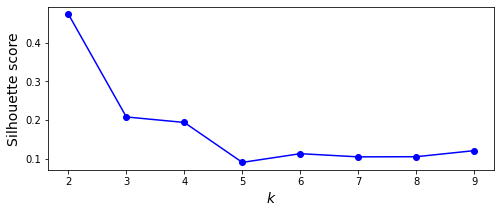

In [93]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [94]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(airbnb_0_prepared)

In [95]:
airbnb_0["cluster"] = kmeans.labels_
airbnb_0.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76669,-12.24525,Apartment,Private room,2,4,1,1,Real Bed,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,0
1,t,strict_14_with_grace_period,f,2,Potrero Hill,37.75645,-12.23991,Apartment,Private room,2,1,1,1,Real Bed,2,272,98.0,10.0,10.0,10.0,10.0,10.0,9.0,155.0,1
2,f,strict_14_with_grace_period,t,2,Western Addition,37.77478,-12.24315,Apartment,Entire home/apt,10,2,4,7,Real Bed,2,31,90.0,9.0,8.0,9.0,9.0,9.0,9.0,450.0,0
3,t,moderate,f,9,Pacific Heights,37.79312,-1.22426,Apartment,Private room,1,0,1,1,Real Bed,30,160,92.0,10.0,9.0,10.0,10.0,10.0,9.0,55.0,1
4,t,moderate,f,9,Pacific Heights,37.79166,-12.24265,Apartment,Entire home/apt,2,1,1,1,Real Bed,30,38,93.0,9.0,9.0,10.0,10.0,10.0,9.0,115.0,1


In [96]:
airbnb_0.groupby("cluster").mean()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
cluster,,,,,,,,,,,,,,,,,
0,59.461538,35.154005,-11.960463,3.589744,1.820513,1.641026,2.589744,20.410256,13.871795,76.871795,8.000000,7.512821,8.743590,8.512821,8.538462,7.538462,149.230769
1,51.933735,34.216035,-10.979870,3.096386,1.204819,1.292169,1.674699,15.194277,43.219880,97.015060,9.917169,9.786145,9.960843,9.960843,9.796687,9.626506,197.686747


In [97]:
airbnb_0_with_dummies = pd.get_dummies(airbnb_0, prefix=categorical_variables)
airbnb_0_with_dummies = airbnb_0_with_dummies.drop(["cluster"], axis=1)
airbnb_0_with_dummies.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,host_is_superhost_f,host_is_superhost_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,instant_bookable_f,instant_bookable_t,neighbourhood_cleansed_Bayview,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,neighbourhood_cleansed_Downtown/Civic Center,neighbourhood_cleansed_Excelsior,neighbourhood_cleansed_Financial District,neighbourhood_cleansed_Glen Park,neighbourhood_cleansed_Golden Gate Park,neighbourhood_cleansed_Haight Ashbury,neighbourhood_cleansed_Inner Richmond,neighbourhood_cleansed_Inner Sunset,neighbourhood_cleansed_Lakeshore,neighbourhood_cleansed_Marina,neighbourhood_cleansed_Mission,neighbourhood_cleansed_Nob Hill,neighbourhood_cleansed_Noe Valley,neighbourhood_cleansed_North Beach,neighbourhood_cleansed_Ocean View,neighbourhood_cleansed_Outer Mission,neighbourhood_cleansed_Outer Richmond,neighbourhood_cleansed_Outer Sunset,neighbourhood_cleansed_Pacific Heights,neighbourhood_cleansed_Parkside,neighbourhood_cleansed_Potrero Hill,neighbourhood_cleansed_Presidio Heights,neighbourhood_cleansed_Russian Hill,neighbourhood_cleansed_Seacliff,neighbourhood_cleansed_South of Market,neighbourhood_cleansed_Twin Peaks,neighbourhood_cleansed_Visitacion Valley,neighbourhood_cleansed_West of Twin Peaks,neighbourhood_cleansed_Western Addition,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boutique hotel,property_type_Bungalow,property_type_Condominium,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_Loft,property_type_Serviced apartment,property_type_Townhouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,10,37.76669,-12.24525,2,4,1,1,32,17,85.0,8.0,8.0,9.0,9.0,9.0,8.0,65.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,2,37.75645,-12.23991,2,1,1,1,2,272,98.0,10.0,10.0,10.0,10.0,10.0,9.0,155.0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,2,37.77478,-12.24315,10,2,4,7,2,31,90.0,9.0,8.0,9.0,9.0,9.0,9.0,450.0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,9,37.79312,-1.22426,1,0,1,1,30,160,92.0,10.0,9.0,10.0,10.0,10.0,9.0,55.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,9,37.79166,-12.24265,2,1,1,1,30,38,93.0,9.0,9.0,10.0,10.0,10.0,9.0,115.0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [98]:
airbnb_0_with_dummies.shape

(703, 85)

In [99]:
_, num_columns = airbnb_0_with_dummies.shape

In [100]:
clf = RandomForestClassifier(random_state=42)

clf.fit(airbnb_0_prepared, airbnb_0["cluster"].values)

sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]

most_important_features = np.take_along_axis(
    np.array(airbnb_0_with_dummies.iloc[:, 0:num_columns].columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

list(zip(most_important_features, most_important_weights))

[('review_scores_rating', 0.20982479235791998),
 ('review_scores_cleanliness', 0.11882451026576418),
 ('review_scores_value', 0.10926164575495537),
 ('review_scores_accuracy', 0.10253231336989364),
 ('review_scores_checkin', 0.07723320243074942),
 ('review_scores_communication', 0.06835660388937462),
 ('review_scores_location', 0.039563934867642425),
 ('price', 0.024659105248181875),
 ('longitude', 0.02412091373114173),
 ('latitude', 0.019942027103032417),
 ('host_total_listings_count', 0.019861625584040973),
 ('beds', 0.01910402868284292),
 ('accommodates', 0.01726898154676663),
 ('number_of_reviews', 0.016840307995894088),
 ('bathrooms', 0.015702591015259202),
 ('bedrooms', 0.013821756818059115),
 ('minimum_nights', 0.009936571347043267),
 ('property_type_Apartment', 0.005365256375342836),
 ('instant_bookable_t', 0.004923341996002223),
 ('neighbourhood_cleansed_Western Addition', 0.004737979807561482),
 ('room_type_Entire home/apt', 0.004605312561386395),
 ('cancellation_policy_moder

In [101]:
save_to_csv(airbnb_0, "kmeans_cluster_based_on_numerical_and_categorical_variables_0.csv")

### Cluster 1

In [102]:
airbnb_1 = airbnb[airbnb["cluster"] == 1].reset_index(drop=True)
airbnb_1.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,t,moderate,t,1,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1,1,2,Real Bed,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,1
1,f,strict_14_with_grace_period,f,2,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1,2,3,Real Bed,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,1
2,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4,1,1,Real Bed,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,1
3,f,strict_14_with_grace_period,f,2,Western Addition,37.77525,-122.43637,House,Entire home/apt,5,1,2,2,Real Bed,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0,1
4,f,moderate,f,1,Western Addition,37.78471,-122.44555,Apartment,Entire home/apt,6,1,2,3,Real Bed,2,31,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0,1


In [103]:
airbnb_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6443 entries, 0 to 6442
Data columns (total 25 columns):
host_is_superhost              6443 non-null object
cancellation_policy            6443 non-null object
instant_bookable               6443 non-null object
host_total_listings_count      6443 non-null int64
neighbourhood_cleansed         6443 non-null object
latitude                       6443 non-null float64
longitude                      6443 non-null float64
property_type                  6443 non-null object
room_type                      6443 non-null object
accommodates                   6443 non-null int64
bathrooms                      6443 non-null int64
bedrooms                       6443 non-null int64
beds                           6443 non-null int64
bed_type                       6443 non-null object
minimum_nights                 6443 non-null int64
number_of_reviews              6443 non-null int64
review_scores_rating           6443 non-null float64
review_scores

In [104]:
airbnb_1.describe()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
count,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.000000,6443.0
mean,52.632625,34.312453,-122.430756,3.209530,1.280925,1.346112,1.768741,15.854260,43.767965,96.049201,9.821357,9.703865,9.896166,9.871954,9.718299,9.525842,215.307776,1.0
std,177.901299,10.332250,0.026855,1.914711,0.772020,0.928537,1.172847,22.965986,72.870254,6.280806,0.587485,0.689543,0.435454,0.508750,0.654755,0.747805,323.756167,0.0
min,0.000000,0.000377,-122.513060,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,10.000000,1.0
25%,1.000000,37.742430,-122.443055,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,95.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,100.000000,1.0
50%,2.000000,37.762840,-122.425690,2.000000,1.000000,1.000000,1.000000,4.000000,12.000000,98.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,150.000000,1.0
75%,8.000000,37.781455,-122.411160,4.000000,1.000000,2.000000,2.000000,30.000000,54.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,235.000000,1.0
max,1199.000000,37.810310,-122.369790,16.000000,10.000000,7.000000,12.000000,365.000000,677.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10000.000000,1.0


In [105]:
airbnb_1 = airbnb_1.drop("cluster", axis=1)
airbnb_1.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
0,t,moderate,t,1,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1,1,2,Real Bed,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0
1,f,strict_14_with_grace_period,f,2,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1,2,3,Real Bed,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0
2,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4,1,1,Real Bed,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0
3,f,strict_14_with_grace_period,f,2,Western Addition,37.77525,-122.43637,House,Entire home/apt,5,1,2,2,Real Bed,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0
4,f,moderate,f,1,Western Addition,37.78471,-122.44555,Apartment,Entire home/apt,6,1,2,3,Real Bed,2,31,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0


In [106]:
categorical_variables = []
for column in list(airbnb_1.columns):
    if airbnb_1[column].dtype == "O":
        categorical_variables.append(column)

numerical_variables = []
for column in list(airbnb_1.columns):
    if airbnb_1[column].dtype != "O":
        numerical_variables.append(column)

In [107]:
categorical_variables

['host_is_superhost',
 'cancellation_policy',
 'instant_bookable',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bed_type']

In [108]:
numerical_variables

['host_total_listings_count',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'minimum_nights',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'price']

In [109]:
num_pipeline = Pipeline([
    ("std_scaler", StandardScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_variables),
    ("cat", OneHotEncoder(), categorical_variables),
])

airbnb_1_prepared = full_pipeline.fit_transform(airbnb_1)

In [110]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(airbnb_1_prepared)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(airbnb_1_prepared, model.labels_)
                     for model in kmeans_per_k[1:]]

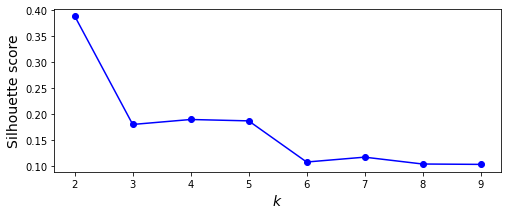

In [111]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

In [112]:
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(airbnb_1_prepared)

In [113]:
airbnb_1["cluster"] = kmeans.labels_
airbnb_1.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,cluster
0,t,moderate,t,1,Western Addition,37.76931,-122.43386,Apartment,Entire home/apt,3,1,1,2,Real Bed,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,1
1,f,strict_14_with_grace_period,f,2,Bernal Heights,37.74511,-122.42102,Apartment,Entire home/apt,5,1,2,3,Real Bed,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,1
2,f,strict_14_with_grace_period,f,10,Haight Ashbury,37.76487,-122.45183,Apartment,Private room,2,4,1,1,Real Bed,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,1
3,f,strict_14_with_grace_period,f,2,Western Addition,37.77525,-122.43637,House,Entire home/apt,5,1,2,2,Real Bed,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0,1
4,f,moderate,f,1,Western Addition,37.78471,-122.44555,Apartment,Entire home/apt,6,1,2,3,Real Bed,2,31,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0,1


In [114]:
airbnb_1.groupby("cluster").mean()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price
cluster,,,,,,,,,,,,,,,,,
0,39.402597,33.330706,-122.428664,2.766234,1.400433,1.11039,1.642857,26.049784,26.558442,81.034632,8.519481,8.196970,9.015152,8.792208,8.759740,8.110390,150.324675
1,53.654573,34.388287,-122.430918,3.243772,1.271694,1.36432,1.778465,15.066711,45.097308,97.208995,9.921919,9.820264,9.964220,9.955359,9.792342,9.635178,220.327370


In [115]:
airbnb_1_with_dummies = pd.get_dummies(airbnb_1, prefix=categorical_variables)
airbnb_1_with_dummies = airbnb_1_with_dummies.drop(["cluster"], axis=1)
airbnb_1_with_dummies.head()

,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,price,host_is_superhost_f,host_is_superhost_t,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict_14_with_grace_period,cancellation_policy_super_strict_30,cancellation_policy_super_strict_60,instant_bookable_f,instant_bookable_t,neighbourhood_cleansed_Bayview,neighbourhood_cleansed_Bernal Heights,neighbourhood_cleansed_Castro/Upper Market,neighbourhood_cleansed_Chinatown,neighbourhood_cleansed_Crocker Amazon,neighbourhood_cleansed_Diamond Heights,neighbourhood_cleansed_Downtown/Civic Center,neighbourhood_cleansed_Excelsior,neighbourhood_cleansed_Financial District,neighbourhood_cleansed_Glen Park,neighbourhood_cleansed_Golden Gate Park,neighbourhood_cleansed_Haight Ashbury,neighbourhood_cleansed_Inner Richmond,neighbourhood_cleansed_Inner Sunset,neighbourhood_cleansed_Lakeshore,neighbourhood_cleansed_Marina,neighbourhood_cleansed_Mission,neighbourhood_cleansed_Nob Hill,neighbourhood_cleansed_Noe Valley,neighbourhood_cleansed_North Beach,neighbourhood_cleansed_Ocean View,neighbourhood_cleansed_Outer Mission,neighbourhood_cleansed_Outer Richmond,neighbourhood_cleansed_Outer Sunset,neighbourhood_cleansed_Pacific Heights,neighbourhood_cleansed_Parkside,neighbourhood_cleansed_Potrero Hill,neighbourhood_cleansed_Presidio,neighbourhood_cleansed_Presidio Heights,neighbourhood_cleansed_Russian Hill,neighbourhood_cleansed_Seacliff,neighbourhood_cleansed_South of Market,neighbourhood_cleansed_Twin Peaks,neighbourhood_cleansed_Visitacion Valley,neighbourhood_cleansed_West of Twin Peaks,neighbourhood_cleansed_Western Addition,property_type_Aparthotel,property_type_Apartment,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Castle,property_type_Condominium,property_type_Cottage,property_type_Earth house,property_type_Guest suite,property_type_Guesthouse,property_type_Hostel,property_type_Hotel,property_type_House,property_type_In-law,property_type_Loft,property_type_Other,property_type_Resort,property_type_Serviced apartment,property_type_Timeshare,property_type_Tiny house,property_type_Townhouse,property_type_Treehouse,property_type_Villa,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed
0,1,37.76931,-122.43386,3,1,1,2,1,180,97.0,10.0,10.0,10.0,10.0,10.0,10.0,170.0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,2,37.74511,-122.42102,5,1,2,3,30,111,98.0,10.0,10.0,10.0,10.0,10.0,9.0,235.0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,10,37.76487,-122.45183,2,4,1,1,32,8,93.0,9.0,9.0,10.0,10.0,9.0,9.0,65.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,2,37.77525,-122.43637,5,1,2,2,7,27,97.0,10.0,10.0,10.0,10.0,10.0,9.0,785.0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,1,37.78471,-122.44555,6,1,2,3,2,31,90.0,9.0,8.0,10.0,10.0,9.0,9.0,255.0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [116]:
airbnb_1_with_dummies.shape

(6443, 97)

In [117]:
_, num_columns = airbnb_1_with_dummies.shape

In [118]:
clf = RandomForestClassifier(random_state=42)

clf.fit(airbnb_1_prepared, airbnb_1["cluster"].values)

sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]

most_important_features = np.take_along_axis(
    np.array(airbnb_1_with_dummies.iloc[:, 0:num_columns].columns.tolist()), 
    sorted_feature_weight_idxes, axis=0)
most_important_weights = np.take_along_axis(
    np.array(clf.feature_importances_), 
    sorted_feature_weight_idxes, axis=0)

# Show
list(zip(most_important_features, most_important_weights))

[('review_scores_rating', 0.18484433537218767),
 ('review_scores_cleanliness', 0.12930210950731486),
 ('review_scores_checkin', 0.12550408086878087),
 ('review_scores_communication', 0.11075136614742036),
 ('review_scores_accuracy', 0.08696321273912691),
 ('review_scores_value', 0.07390544625782786),
 ('review_scores_location', 0.03594843985842128),
 ('price', 0.02999128115984215),
 ('latitude', 0.022990643210574504),
 ('longitude', 0.022383825579864645),
 ('number_of_reviews', 0.02020950679568561),
 ('host_total_listings_count', 0.019105155932340176),
 ('minimum_nights', 0.013938386170342598),
 ('accommodates', 0.010062500414369898),
 ('beds', 0.008050371830063418),
 ('bedrooms', 0.007103116169657423),
 ('host_is_superhost_t', 0.006852974067572356),
 ('host_is_superhost_f', 0.006184178613088028),
 ('bathrooms', 0.004839912691076327),
 ('cancellation_policy_strict_14_with_grace_period', 0.004389286786334867),
 ('instant_bookable_f', 0.004115612217567498),
 ('property_type_Apartment', 0

In [119]:
save_to_csv(airbnb_1, "kmeans_cluster_based_on_numerical_and_categorical_variables_1.csv")